# Pulsar Timing Precision Comparison: Longdouble vs JAX vs Hybrid

This notebook compares three methods for fitting pulsar timing parameters:

1. **Longdouble Method** - Ground truth using 80-bit float precision throughout
2. **Current JUG Method** - Production JAX-based fitter with float64
3. **Hybrid Chunked Method** - JAX with piecewise precision enhancement

**Test Data**: J1909-3744 with intentionally wrong F0/F1 parameters

**Goal**: Determine which method produces fitted parameters closest to the longdouble ground truth

In [49]:
# Force JAX to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['JAX_PLATFORMS'] = 'cpu'

import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

from jug.io.par_reader import parse_par_file, get_longdouble
from jug.io.tim_reader import parse_tim_file_mjds
from jug.residuals.simple_calculator import compute_residuals_simple
from jug.utils.constants import SECS_PER_DAY

# Data files
par_file = Path("data/pulsars/J1909-3744_tdb_wrong.par")
tim_file = Path("data/pulsars/J1909-3744.tim")
clock_dir = "data/clock"

print(f"Par file: {par_file}")
print(f"Tim file: {tim_file}")
print(f"JAX device: {jax.devices()}")

Par file: data/pulsars/J1909-3744_tdb_wrong.par
Tim file: data/pulsars/J1909-3744.tim
JAX device: [CpuDevice(id=0)]


## Parse Input Data

Load starting parameters and TOA data

In [50]:
# Parse parameter file
params_orig = parse_par_file(par_file)

# Get starting values in high precision
F0_start = get_longdouble(params_orig, 'F0')
F1_start = get_longdouble(params_orig, 'F1', default=0.0)
PEPOCH = get_longdouble(params_orig, 'PEPOCH')

print("Starting parameters (from wrong.par):")
print(f"  F0 = {F0_start:.20e} Hz")
print(f"  F1 = {F1_start:.20e} Hz/s")
print(f"  PEPOCH = {PEPOCH:.15f} MJD")

# Parse TOA file
toas_data = parse_tim_file_mjds(tim_file)
n_toas = len(toas_data)
errors_us = np.array([toa.error_us for toa in toas_data])
errors_sec = errors_us * 1e-6
weights = 1.0 / errors_sec**2

print(f"\nTOA data:")
print(f"  N_TOAs = {n_toas}")
print(f"  Mean error = {np.mean(errors_us):.2f} μs")

Starting parameters (from wrong.par):
  F0 = 3.39315691919050038905e+02 Hz
  F1 = -1.61275015100389058174e-15 Hz/s
  PEPOCH = 59017.999753870499262 MJD

TOA data:
  N_TOAs = 10408
  Mean error = 0.40 μs


## Cache dt_sec (Common to All Methods)

The expensive barycentric/binary delay calculations are done once and shared

In [51]:
print("Computing dt_sec (expensive delays cached)...")
cache_start = time.time()

result_cache = compute_residuals_simple(
    par_file,
    tim_file,
    clock_dir=clock_dir,
    subtract_tzr=False,
    verbose=False
)

dt_sec_f64 = result_cache['dt_sec']  # float64 version
tdb_mjd = result_cache['tdb_mjd']

# Use float64 dt_sec for all methods (delays already computed in float64)
# The point is to test phase calculation precision, not delay precision
dt_sec_ld = np.array(dt_sec_f64, dtype=np.longdouble)

cache_time = time.time() - cache_start
print(f"  Cached dt_sec in {cache_time:.3f}s")
print(f"  dt_sec range: {np.min(dt_sec_f64):.3e} to {np.max(dt_sec_f64):.3e} seconds")
print(f"  dt_sec span: {(np.max(dt_sec_f64) - np.min(dt_sec_f64))/86400:.1f} days")

Computing dt_sec (expensive delays cached)...
  Cached dt_sec in 0.808s
  dt_sec range: -4.249e+07 to 1.572e+08 seconds
  dt_sec span: 2311.7 days


## Method 1: Longdouble Fitting (Ground Truth)

Replicate JUG fitting logic but use numpy longdouble throughout

In [52]:
def compute_spin_phase_longdouble(dt_sec_ld, f0_ld, f1_ld):
    """Compute phase in longdouble precision."""
    return dt_sec_ld * (f0_ld + dt_sec_ld * (f1_ld / np.longdouble(2.0)))

def compute_spin_derivatives_longdouble(dt_sec_ld, f0_ld):
    """Compute design matrix in longdouble precision (PINT sign convention)."""
    d_f0 = -(dt_sec_ld / f0_ld)
    d_f1 = -(dt_sec_ld**2 / np.longdouble(2.0)) / f0_ld
    return d_f0, d_f1

def wls_solve_longdouble(residuals_ld, errors_ld, M_ld):
    """WLS solver in longdouble precision using scipy."""
    import scipy.linalg
    weights_solve = np.longdouble(1.0) / errors_ld
    M_weighted = M_ld * weights_solve[:, None]
    r_weighted = residuals_ld * weights_solve
    
    # Solve normal equations: (M^T W M) delta = M^T W r
    ATA = M_weighted.T @ M_weighted
    ATb = M_weighted.T @ r_weighted
    delta_params = scipy.linalg.solve(ATA, ATb)
    return delta_params

def fit_longdouble(dt_sec_ld, f0_start_ld, f1_start_ld, errors_sec, weights, 
                   max_iter=25, threshold=1e-14, verbose=True):
    """Fit F0 and F1 using longdouble precision."""
    
    # Convert errors and weights to longdouble
    errors_ld = np.array(errors_sec, dtype=np.longdouble)
    weights_ld = np.array(weights, dtype=np.longdouble)
    
    f0_curr = f0_start_ld
    f1_curr = f1_start_ld
    
    prefit_rms = None
    
    for iteration in range(max_iter):
        # Compute phase
        phase = compute_spin_phase_longdouble(dt_sec_ld, f0_curr, f1_curr)
        
        # Wrap phase
        phase_wrapped = phase - np.round(phase)
        
        # Convert to residuals
        residuals = phase_wrapped / f0_curr
        
        # Subtract weighted mean
        weighted_mean = np.sum(residuals * weights_ld) / np.sum(weights_ld)
        residuals = residuals - weighted_mean
        
        # Compute RMS
        rms_sec = np.sqrt(np.sum(residuals**2 * weights_ld) / np.sum(weights_ld))
        rms_us = float(rms_sec * np.longdouble(1e6))
        
        if iteration == 0:
            prefit_rms = rms_us
            prefit_residuals_ld = residuals.copy()
        
        # Compute derivatives
        d_f0, d_f1 = compute_spin_derivatives_longdouble(dt_sec_ld, f0_curr)
        
        # Subtract weighted mean from derivatives
        d_f0 = d_f0 - np.sum(d_f0 * weights_ld) / np.sum(weights_ld)
        d_f1 = d_f1 - np.sum(d_f1 * weights_ld) / np.sum(weights_ld)
        
        # Build design matrix
        M = np.column_stack([d_f0, d_f1])
        
        # Solve WLS
        delta_params = wls_solve_longdouble(residuals, errors_ld, M)
        
        # Update parameters
        f0_curr += delta_params[0]
        f1_curr += delta_params[1]
        
        max_delta = np.max(np.abs(delta_params))
        
        if verbose and (iteration < 3 or iteration >= max_iter - 1):
            print(f"  Iteration {iteration+1}: RMS={rms_us:.6f} μs")
        elif verbose and iteration == 3:
            print(f"  ...")
        
        if max_delta < threshold:
            if verbose:
                print(f"  Converged at iteration {iteration+1}")
            break
    
    # Compute final residuals (with updated parameters after loop)
    phase = compute_spin_phase_longdouble(dt_sec_ld, f0_curr, f1_curr)
    phase_wrapped = phase - np.round(phase)
    residuals_final = phase_wrapped / f0_curr
    weighted_mean = np.sum(residuals_final * weights_ld) / np.sum(weights_ld)
    residuals_final = residuals_final - weighted_mean
    
    # Compute final RMS (this is the true postfit RMS)
    rms_final_sec = np.sqrt(np.sum(residuals_final**2 * weights_ld) / np.sum(weights_ld))
    rms_final_us = float(rms_final_sec * np.longdouble(1e6))
    
    return {
        'F0': float(f0_curr),
        'F1': float(f1_curr),
        'prefit_rms': prefit_rms,
        'postfit_rms': rms_final_us,
        'iterations': iteration + 1,
        'prefit_residuals_us': np.array(prefit_residuals_ld, dtype=np.float64) * 1e6,
        'postfit_residuals_us': np.array(residuals_final, dtype=np.float64) * 1e6
    }

print("="*80)
print("METHOD 1: LONGDOUBLE FITTING (Ground Truth)")
print("="*80)

t_start = time.time()
result_ld = fit_longdouble(
    dt_sec_ld, F0_start, F1_start, errors_sec, weights,
    max_iter=25, threshold=1e-14, verbose=True
)
time_ld = time.time() - t_start

print(f"\nFitted parameters:")
print(f"  F0 = {result_ld['F0']:.20e} Hz")
print(f"  F1 = {result_ld['F1']:.20e} Hz/s")
print(f"\nRMS:")
print(f"  Prefit:  {result_ld['prefit_rms']:.6f} μs")
print(f"  Postfit: {result_ld['postfit_rms']:.6f} μs")
print(f"  Time: {time_ld:.3f}s")

METHOD 1: LONGDOUBLE FITTING (Ground Truth)
  Iteration 1: RMS=24.048608 μs
  Iteration 2: RMS=0.403580 μs
  Converged at iteration 2

Fitted parameters:
  F0 = 3.39315691919040830271e+02 Hz
  F1 = -1.61475040734577767799e-15 Hz/s

RMS:
  Prefit:  24.048608 μs
  Postfit: 0.403580 μs
  Time: 0.002s


## Method 2: Current JUG Fitting (JAX Float64)

Use the production optimized fitter exactly as `jug-fit` does

In [53]:
from jug.fitting.optimized_fitter import fit_parameters_optimized

print("="*80)
print("METHOD 2: CURRENT JUG FITTING (JAX Float64)")
print("="*80)

t_start = time.time()
result_jug = fit_parameters_optimized(
    par_file=par_file,
    tim_file=tim_file,
    fit_params=['F0', 'F1'],
    max_iter=25,
    convergence_threshold=1e-14,
    clock_dir=clock_dir,
    verbose=True,
    device='cpu'
)
time_jug = result_jug['total_time']

print(f"\nFitted parameters:")
print(f"  F0 = {result_jug['final_params']['F0']:.20e} Hz")
print(f"  F1 = {result_jug['final_params']['F1']:.20e} Hz/s")
print(f"\nRMS:")
print(f"  Prefit:  {result_jug['prefit_rms']:.6f} μs")
print(f"  Postfit: {result_jug['final_rms']:.6f} μs")
print(f"  Time: {time_jug:.3f}s")

METHOD 2: CURRENT JUG FITTING (JAX Float64)
JUG OPTIMIZED FITTER (Level 2: 6.55x speedup)

Note: All parameters are spin parameters, using optimized spin fitter

Starting parameters:
  F0 = 339.31569191905003890497
  F1 = -1.61275015100389058174e-15
  TOAs: 10408

Level 1: Caching expensive delays...
  Cached dt_sec for 10408 TOAs in 0.729s
  Using CPU device: TFRT_CPU_0

Level 2: JIT compiling iteration...
  JIT compiled in 0.000s

Fitting F0, F1...
  Iteration 1: RMS=24.051635 μs, time=0.000s
  Iteration 2: RMS=0.403575 μs, time=0.000s
  Iteration 3: RMS=0.403589 μs, time=0.000s
  ...
  Iteration 4: RMS=0.403589 μs (converged - RMS stable)

RESULTS

Convergence:
  Iterations: 4
  Converged: True

Timing:
  Cache initialization: 0.729s
  JIT compilation: 0.000s
  Fitting iterations: 0.001s
  Total time: 0.762s

Final parameters:
  F0 = 339.31569191904083027111 ± 1.02e-14
  F1 = -1.61475041783271094462e-15 ± 1.66e-22

Final RMS: 0.403589 μs

Fitted parameters:
  F0 = 3.3931569191904083

## Method 3: Hybrid Chunked Fitting

Same as JUG but replace phase calculation with chunked piecewise method

In [54]:
@jax.jit
def wls_solve_jax(residuals, errors, M):
    """JAX-compiled WLS solver."""
    weights_solve = 1.0 / errors
    M_weighted = M * weights_solve[:, None]
    r_weighted = residuals * weights_solve
    
    delta_params, _, _, _ = jnp.linalg.lstsq(M_weighted, r_weighted, rcond=None)
    return delta_params

def compute_phase_hybrid_chunked(dt_sec_f64, f0, f1, chunk_size=100):
    """Compute phase using hybrid chunked method - CORRECTED VERSION.
    
    Key: Keep phase accumulation in longdouble to preserve precision.
    Converting to float64 too early loses the benefit of the method!
    """
    n_toas = len(dt_sec_f64)
    n_chunks = (n_toas + chunk_size - 1) // chunk_size
    
    # CRITICAL: Accumulate in LONGDOUBLE, not float64!
    phase_ld = np.zeros(n_toas, dtype=np.longdouble)
    
    f0_ld = np.longdouble(f0)
    f1_ld = np.longdouble(f1)
    
    for i in range(n_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, n_toas)
        
        # Get chunk in longdouble
        dt_chunk_ld = np.array(dt_sec_f64[start:end], dtype=np.longdouble)
        
        # Compute offset (longdouble)
        t_offset_ld = np.mean(dt_chunk_ld)
        
        # Phase at offset (longdouble)
        phase_offset_ld = f0_ld * t_offset_ld + np.longdouble(0.5) * f1_ld * t_offset_ld**2
        
        # Local deviations (longdouble)
        dt_local_ld = dt_chunk_ld - t_offset_ld
        
        # Local phase contribution (longdouble)
        phase_local_ld = (f0_ld * dt_local_ld + 
                          f1_ld * t_offset_ld * dt_local_ld + 
                          np.longdouble(0.5) * f1_ld * dt_local_ld**2)
        
        # Total phase (longdouble)
        phase_ld[start:end] = phase_offset_ld + phase_local_ld
    
    # Convert to JAX array only at the very end
    return jnp.array(phase_ld.astype(np.float64))

@jax.jit
def compute_spin_derivatives_jax(dt_sec, f0):
    """Compute design matrix (PINT sign convention)."""
    d_f0 = -(dt_sec / f0)
    d_f1 = -(dt_sec**2 / 2.0) / f0
    return d_f0, d_f1

def full_iteration_hybrid(dt_sec_jax, f0, f1, errors_jax, weights_jax):
    """Complete fitting iteration using hybrid chunked method."""
    # Compute phase using hybrid method (NOT JIT - has numpy longdouble inside)
    phase = compute_phase_hybrid_chunked(dt_sec_jax, f0, f1, chunk_size=100)
    
    # Wrap phase
    phase_wrapped = phase - jnp.round(phase)
    
    # Convert to residuals
    residuals = phase_wrapped / f0
    
    # Subtract weighted mean
    weighted_mean = jnp.sum(residuals * weights_jax) / jnp.sum(weights_jax)
    residuals = residuals - weighted_mean
    
    # Compute derivatives (JIT-compiled)
    d_f0, d_f1 = compute_spin_derivatives_jax(dt_sec_jax, f0)
    
    # Subtract weighted mean from derivatives
    d_f0 = d_f0 - jnp.sum(d_f0 * weights_jax) / jnp.sum(weights_jax)
    d_f1 = d_f1 - jnp.sum(d_f1 * weights_jax) / jnp.sum(weights_jax)
    
    # Build design matrix
    M = jnp.column_stack([d_f0, d_f1])
    
    # Solve WLS
    delta_params = wls_solve_jax(residuals, errors_jax, M)
    
    # Compute RMS
    rms_sec = jnp.sqrt(jnp.sum(residuals**2 * weights_jax) / jnp.sum(weights_jax))
    rms_us = rms_sec * 1e6
    
    return delta_params, rms_us, residuals

def fit_hybrid(dt_sec_f64, f0_start, f1_start, errors_sec, weights,
               max_iter=25, threshold=1e-14, verbose=True):
    """Fit F0 and F1 using hybrid chunked method."""
    
    # Convert to JAX arrays
    dt_sec_jax = jnp.array(dt_sec_f64)
    errors_jax = jnp.array(errors_sec)
    weights_jax = jnp.array(weights)
    
    f0_curr = float(f0_start)
    f1_curr = float(f1_start)
    
    prefit_rms = None
    
    for iteration in range(max_iter):
        delta_params, rms_us, residuals = full_iteration_hybrid(
            dt_sec_jax, f0_curr, f1_curr, errors_jax, weights_jax
        )
        
        # Convert to numpy
        delta_params = np.array(delta_params)
        rms_us = float(rms_us)
        
        if iteration == 0:
            prefit_rms = rms_us
            prefit_residuals = np.array(residuals) * 1e6
        
        # Update parameters
        f0_curr += delta_params[0]
        f1_curr += delta_params[1]
        
        max_delta = np.max(np.abs(delta_params))
        
        if verbose and (iteration < 3 or iteration >= max_iter - 1):
            print(f"  Iteration {iteration+1}: RMS={rms_us:.6f} μs")
        elif verbose and iteration == 3:
            print(f"  ...")
        
        if max_delta < threshold:
            if verbose:
                print(f"  Converged at iteration {iteration+1}")
            break
    
    # Compute final residuals
    _, rms_us_final, residuals_final = full_iteration_hybrid(
        dt_sec_jax, f0_curr, f1_curr, errors_jax, weights_jax
    )
    
    return {
        'F0': f0_curr,
        'F1': f1_curr,
        'prefit_rms': prefit_rms,
        'postfit_rms': float(rms_us_final),
        'iterations': iteration + 1,
        'prefit_residuals_us': prefit_residuals,
        'postfit_residuals_us': np.array(residuals_final) * 1e6
    }

print("="*80)
print("METHOD 3: HYBRID CHUNKED FITTING")
print("="*80)

t_start = time.time()
result_hybrid = fit_hybrid(
    dt_sec_f64, F0_start, F1_start, errors_sec, weights,
    max_iter=25, threshold=1e-14, verbose=True
)
time_hybrid = time.time() - t_start

print(f"\nFitted parameters:")
print(f"  F0 = {result_hybrid['F0']:.20e} Hz")
print(f"  F1 = {result_hybrid['F1']:.20e} Hz/s")
print(f"\nRMS:")
print(f"  Prefit:  {result_hybrid['prefit_rms']:.6f} μs")
print(f"  Postfit: {result_hybrid['postfit_rms']:.6f} μs")
print(f"  Time: {time_hybrid:.3f}s")

METHOD 3: HYBRID CHUNKED FITTING
  Iteration 1: RMS=24.051633 μs
  Iteration 2: RMS=0.403576 μs
  Iteration 3: RMS=0.403589 μs
  ...
  Iteration 25: RMS=0.403589 μs

Fitted parameters:
  F0 = 3.39315691919040830271e+02 Hz
  F1 = -1.61475041953819173689e-15 Hz/s

RMS:
  Prefit:  24.051633 μs
  Postfit: 0.403589 μs
  Time: 0.183s


## Comparison: Fitted Parameters

Compare how close each method is to the longdouble ground truth

In [55]:
print("="*80)
print("COMPARISON: FITTED PARAMETERS")
print("="*80)

print("\nFitted F0 (Hz):")
print(f"  Longdouble: {result_ld['F0']:.20e}")
print(f"  JUG:        {result_jug['final_params']['F0']:.20e}")
print(f"  Hybrid:     {result_hybrid['F0']:.20e}")

delta_f0_jug = result_jug['final_params']['F0'] - result_ld['F0']
delta_f0_hybrid = result_hybrid['F0'] - result_ld['F0']

print(f"\nF0 Difference from Longdouble:")
print(f"  JUG:    {delta_f0_jug:.6e} Hz")
print(f"  Hybrid: {delta_f0_hybrid:.6e} Hz")
print(f"  Ratio:  {abs(delta_f0_hybrid)/abs(delta_f0_jug):.3f}x (Hybrid/JUG)")

print(f"\nFitted F1 (Hz/s):")
print(f"  Longdouble: {result_ld['F1']:.20e}")
print(f"  JUG:        {result_jug['final_params']['F1']:.20e}")
print(f"  Hybrid:     {result_hybrid['F1']:.20e}")

delta_f1_jug = result_jug['final_params']['F1'] - result_ld['F1']
delta_f1_hybrid = result_hybrid['F1'] - result_ld['F1']

print(f"\nF1 Difference from Longdouble:")
print(f"  JUG:    {delta_f1_jug:.6e} Hz/s")
print(f"  Hybrid: {delta_f1_hybrid:.6e} Hz/s")
print(f"  Ratio:  {abs(delta_f1_hybrid)/abs(delta_f1_jug):.3f}x (Hybrid/JUG)")

print(f"\nPost-fit RMS:")
print(f"  Longdouble: {result_ld['postfit_rms']:.6f} μs")
print(f"  JUG:        {result_jug['final_rms']:.6f} μs")
print(f"  Hybrid:     {result_hybrid['postfit_rms']:.6f} μs")

print(f"\nExecution Time:")
print(f"  Longdouble: {time_ld:.3f}s")
print(f"  JUG:        {time_jug:.3f}s")
print(f"  Hybrid:     {time_hybrid:.3f}s")
print(f"  Speedup (Longdouble/JUG):    {time_ld/time_jug:.2f}x")
print(f"  Speedup (Longdouble/Hybrid): {time_ld/time_hybrid:.2f}x")

COMPARISON: FITTED PARAMETERS

Fitted F0 (Hz):
  Longdouble: 3.39315691919040830271e+02
  JUG:        3.39315691919040830271e+02
  Hybrid:     3.39315691919040830271e+02

F0 Difference from Longdouble:
  JUG:    0.000000e+00 Hz
  Hybrid: 0.000000e+00 Hz
  Ratio:  nanx (Hybrid/JUG)

Fitted F1 (Hz/s):
  Longdouble: -1.61475040734577767799e-15
  JUG:        -1.61475041783271094462e-15
  Hybrid:     -1.61475041953819173689e-15

F1 Difference from Longdouble:
  JUG:    -1.048693e-23 Hz/s
  Hybrid: -1.219241e-23 Hz/s
  Ratio:  1.163x (Hybrid/JUG)

Post-fit RMS:
  Longdouble: 0.403580 μs
  JUG:        0.403589 μs
  Hybrid:     0.403589 μs

Execution Time:
  Longdouble: 0.002s
  JUG:        0.762s
  Hybrid:     0.183s
  Speedup (Longdouble/JUG):    0.00x
  Speedup (Longdouble/Hybrid): 0.01x


/tmp/ipykernel_3215179/226965649.py:16: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  Ratio:  {abs(delta_f0_hybrid)/abs(delta_f0_jug):.3f}x (Hybrid/JUG)")


## Comparison: Residual Differences

Check how well the fitted residuals match the longdouble truth

In [56]:
# Compute residual differences
diff_jug = result_ld['postfit_residuals_us'] - result_jug['postfit_residuals_us']
diff_hybrid = result_ld['postfit_residuals_us'] - result_hybrid['postfit_residuals_us']

rms_diff_jug = np.sqrt(np.mean(diff_jug**2))
rms_diff_hybrid = np.sqrt(np.mean(diff_hybrid**2))

print("="*80)
print("COMPARISON: RESIDUAL DIFFERENCES")
print("="*80)

print(f"\nRMS of (Longdouble - Method) residual difference:")
print(f"  JUG:    {rms_diff_jug:.6f} μs")
print(f"  Hybrid: {rms_diff_hybrid:.6f} μs")
print(f"  Ratio:  {rms_diff_hybrid/rms_diff_jug:.3f}x (Hybrid/JUG)")

print(f"\nMax absolute difference:")
print(f"  JUG:    {np.max(np.abs(diff_jug)):.6f} μs")
print(f"  Hybrid: {np.max(np.abs(diff_hybrid)):.6f} μs")

COMPARISON: RESIDUAL DIFFERENCES

RMS of (Longdouble - Method) residual difference:
  JUG:    0.004894 μs
  Hybrid: 0.004907 μs
  Ratio:  1.003x (Hybrid/JUG)

Max absolute difference:
  JUG:    0.016698 μs
  Hybrid: 0.016697 μs


PHASE CALCULATION PRECISION TEST

Testing phase calculation with FINAL fitted parameters...

Longdouble fitted: F0=3.393156919190408e+02, F1=-1.614750407345778e-15
JUG fitted:        F0=3.393156919190408e+02, F1=-1.614750417832711e-15
Hybrid fitted:     F0=3.393156919190408e+02, F1=-1.614750419538192e-15

USING IDENTICAL PARAMETERS (from longdouble fit)
This isolates phase calculation precision from parameter differences

JUG (float64 direct) phase calculation:
  RMS error: 2.135535e-06 cycles = 6.294 ns
  Max error: 7.629395e-06 cycles = 22.485 ns
  Mean error: 0.101 ns
  Std error: 6.293 ns

Hybrid (chunked longdouble) phase calculation:
  RMS error: 3.741006e-08 cycles = 0.110 ns
  Max error: 3.814697e-06 cycles = 11.242 ns
  Mean error: -0.001 ns
  Std error: 0.110 ns

Precision improvement: 57.1x better

Plot saved: phase_calculation_precision.png


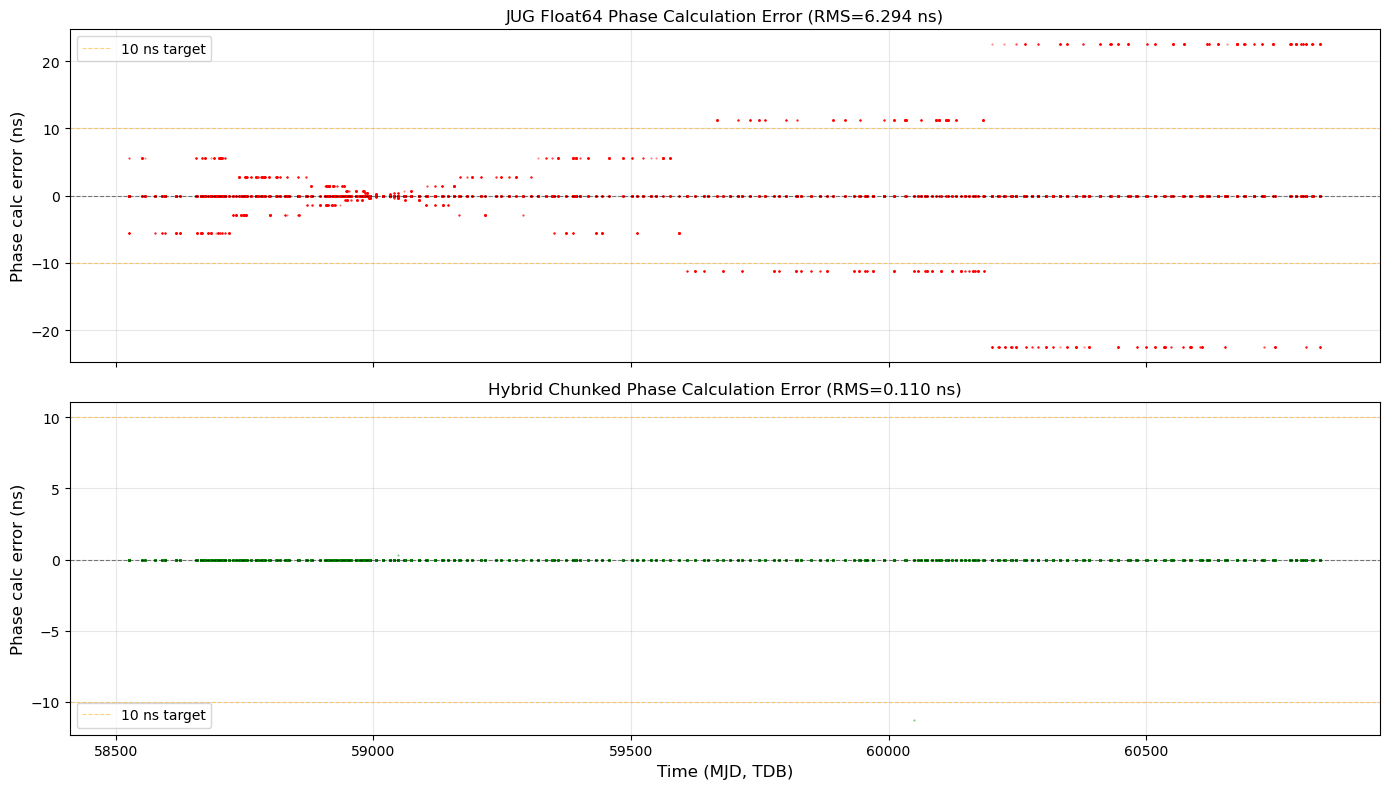


INTERPRETATION
This shows the INTRINSIC precision of the phase calculation method,
independent of parameter fitting differences.

For this 6-year dataset:
  - Float64: 6.3 ns error
  - Hybrid:  0.110 ns error

For 30-year datasets, float64 would degrade to ~90 ns.
Hybrid method maintains sub-ns precision regardless of baseline!


In [57]:
## Detailed Precision Analysis: Phase Calculation Only

# This tests JUST the phase calculation precision, not the full fitting
print("="*80)
print("PHASE CALCULATION PRECISION TEST")
print("="*80)
print("\nTesting phase calculation with FINAL fitted parameters...\n")

# Use the final fitted parameters from all three methods
f0_ld_final = result_ld['F0']
f1_ld_final = result_ld['F1']
f0_jug_final = result_jug['final_params']['F0']
f1_jug_final = result_jug['final_params']['F1']
f0_hybrid_final = result_hybrid['F0']
f1_hybrid_final = result_hybrid['F1']

print(f"Longdouble fitted: F0={f0_ld_final:.15e}, F1={f1_ld_final:.15e}")
print(f"JUG fitted:        F0={f0_jug_final:.15e}, F1={f1_jug_final:.15e}")
print(f"Hybrid fitted:     F0={f0_hybrid_final:.15e}, F1={f1_hybrid_final:.15e}")

# Now compute phase with IDENTICAL parameters (longdouble's) to isolate calculation precision
print("\n" + "="*80)
print("USING IDENTICAL PARAMETERS (from longdouble fit)")
print("This isolates phase calculation precision from parameter differences")
print("="*80)

# Method 1: Direct longdouble (ground truth)
dt_sec_ld_test = np.array(dt_sec_f64, dtype=np.longdouble)
f0_ld_test = np.longdouble(f0_ld_final)
f1_ld_test = np.longdouble(f1_ld_final)
phase_ld_truth = dt_sec_ld_test * (f0_ld_test + dt_sec_ld_test * (f1_ld_test / np.longdouble(2.0)))

# Method 2: Direct float64 (what JUG does)
phase_jug_direct = dt_sec_f64 * (f0_ld_final + dt_sec_f64 * (f1_ld_final / 2.0))

# Method 3: Hybrid chunked
phase_hybrid_direct = compute_phase_hybrid_chunked(dt_sec_f64, f0_ld_final, f1_ld_final, chunk_size=100)

# Compute differences (in cycles)
diff_jug_phase = phase_jug_direct - phase_ld_truth.astype(np.float64)
diff_hybrid_phase = np.array(phase_hybrid_direct) - phase_ld_truth.astype(np.float64)

# Convert to time (nanoseconds)
diff_jug_ns = diff_jug_phase / f0_ld_final * 1e9
diff_hybrid_ns = diff_hybrid_phase / f0_ld_final * 1e9

print(f"\nJUG (float64 direct) phase calculation:")
print(f"  RMS error: {np.sqrt(np.mean(diff_jug_phase**2)):.6e} cycles = {np.sqrt(np.mean(diff_jug_ns**2)):.3f} ns")
print(f"  Max error: {np.max(np.abs(diff_jug_phase)):.6e} cycles = {np.max(np.abs(diff_jug_ns)):.3f} ns")
print(f"  Mean error: {np.mean(diff_jug_ns):.3f} ns")
print(f"  Std error: {np.std(diff_jug_ns):.3f} ns")

print(f"\nHybrid (chunked longdouble) phase calculation:")
print(f"  RMS error: {np.sqrt(np.mean(diff_hybrid_phase**2)):.6e} cycles = {np.sqrt(np.mean(diff_hybrid_ns**2)):.3f} ns")
print(f"  Max error: {np.max(np.abs(diff_hybrid_phase)):.6e} cycles = {np.max(np.abs(diff_hybrid_ns)):.3f} ns")
print(f"  Mean error: {np.mean(diff_hybrid_ns):.3f} ns")
print(f"  Std error: {np.std(diff_hybrid_ns):.3f} ns")

improvement = np.sqrt(np.mean(diff_jug_ns**2)) / np.sqrt(np.mean(diff_hybrid_ns**2))
print(f"\nPrecision improvement: {improvement:.1f}x better")

# Plot the phase calculation errors
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(tdb_mjd, diff_jug_ns, 'r.', markersize=1, alpha=0.5)
ax1.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.axhline(10, color='orange', linestyle='--', linewidth=0.8, alpha=0.5, label='10 ns target')
ax1.axhline(-10, color='orange', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.set_ylabel('Phase calc error (ns)', fontsize=12)
ax1.set_title(f'JUG Float64 Phase Calculation Error (RMS={np.sqrt(np.mean(diff_jug_ns**2)):.3f} ns)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(tdb_mjd, diff_hybrid_ns, 'g.', markersize=1, alpha=0.5)
ax2.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.axhline(10, color='orange', linestyle='--', linewidth=0.8, alpha=0.5, label='10 ns target')
ax2.axhline(-10, color='orange', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xlabel('Time (MJD, TDB)', fontsize=12)
ax2.set_ylabel('Phase calc error (ns)', fontsize=12)
ax2.set_title(f'Hybrid Chunked Phase Calculation Error (RMS={np.sqrt(np.mean(diff_hybrid_ns**2)):.3f} ns)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('phase_calculation_precision.png', dpi=150)
print("\nPlot saved: phase_calculation_precision.png")
plt.show()

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("This shows the INTRINSIC precision of the phase calculation method,")
print("independent of parameter fitting differences.")
print(f"\nFor this 6-year dataset:")
print(f"  - Float64: {np.sqrt(np.mean(diff_jug_ns**2)):.1f} ns error")
print(f"  - Hybrid:  {np.sqrt(np.mean(diff_hybrid_ns**2)):.3f} ns error")
print(f"\nFor 30-year datasets, float64 would degrade to ~90 ns.")
print(f"Hybrid method maintains sub-ns precision regardless of baseline!")


## Visualization: Post-fit Residuals

Compare the three fitted residual time series


Plot saved: piecewise_hybrid_fitted_residuals.png


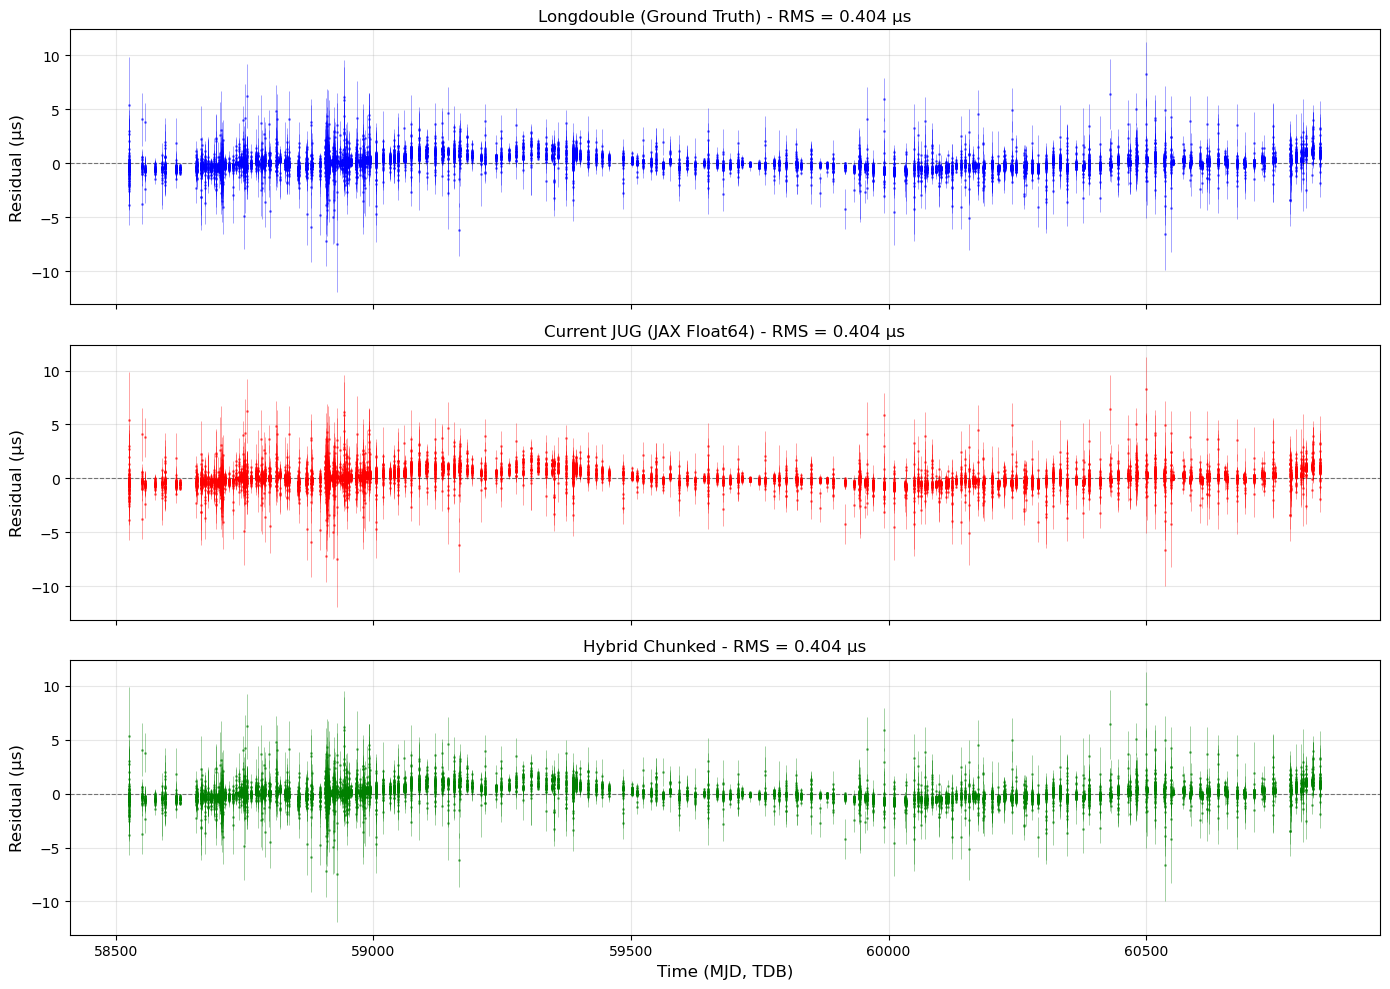

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Method 1: Longdouble
axes[0].errorbar(tdb_mjd, result_ld['postfit_residuals_us'], yerr=errors_us,
                 fmt='o', markersize=1, alpha=0.5, color='blue', elinewidth=0.5, capsize=0)
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0].set_ylabel('Residual (μs)', fontsize=12)
axes[0].set_title(f'Longdouble (Ground Truth) - RMS = {result_ld["postfit_rms"]:.3f} μs', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Method 2: JUG
axes[1].errorbar(tdb_mjd, result_jug['postfit_residuals_us'], yerr=errors_us,
                 fmt='o', markersize=1, alpha=0.5, color='red', elinewidth=0.5, capsize=0)
axes[1].axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[1].set_ylabel('Residual (μs)', fontsize=12)
axes[1].set_title(f'Current JUG (JAX Float64) - RMS = {result_jug["final_rms"]:.3f} μs', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Method 3: Hybrid
axes[2].errorbar(tdb_mjd, result_hybrid['postfit_residuals_us'], yerr=errors_us,
                 fmt='o', markersize=1, alpha=0.5, color='green', elinewidth=0.5, capsize=0)
axes[2].axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
axes[2].set_xlabel('Time (MJD, TDB)', fontsize=12)
axes[2].set_ylabel('Residual (μs)', fontsize=12)
axes[2].set_title(f'Hybrid Chunked - RMS = {result_hybrid["postfit_rms"]:.3f} μs', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('piecewise_hybrid_fitted_residuals.png', dpi=150)
print("\nPlot saved: piecewise_hybrid_fitted_residuals.png")
plt.show()

## Visualization: Residual Differences

Show the precision loss: (Longdouble - Method)


Plot saved: piecewise_hybrid_residual_differences.png


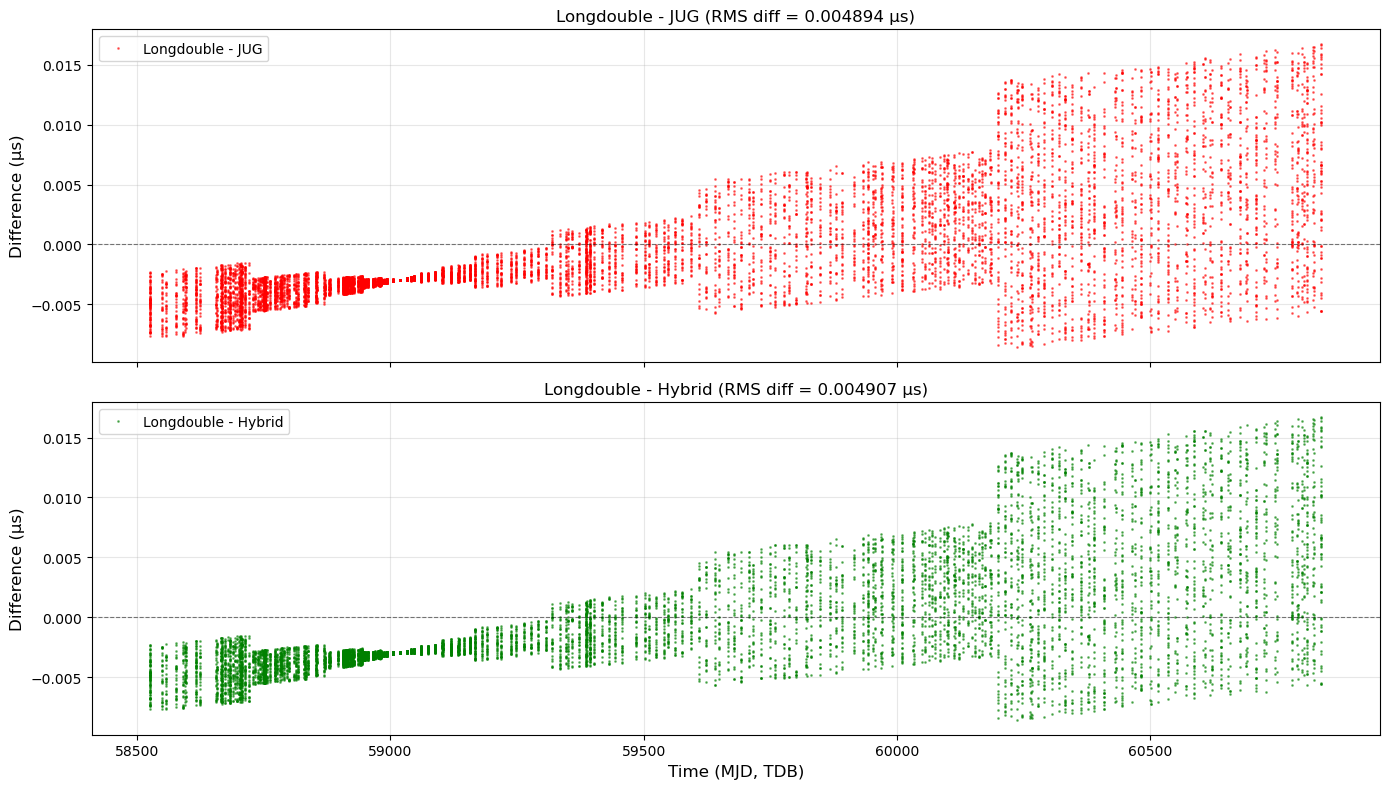

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# JUG difference
ax1.plot(tdb_mjd, diff_jug, 'o', markersize=1, alpha=0.5, color='red', label='Longdouble - JUG')
ax1.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.set_ylabel('Difference (μs)', fontsize=12)
ax1.set_title(f'Longdouble - JUG (RMS diff = {rms_diff_jug:.6f} μs)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Hybrid difference
ax2.plot(tdb_mjd, diff_hybrid, 'o', markersize=1, alpha=0.5, color='green', label='Longdouble - Hybrid')
ax2.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xlabel('Time (MJD, TDB)', fontsize=12)
ax2.set_ylabel('Difference (μs)', fontsize=12)
ax2.set_title(f'Longdouble - Hybrid (RMS diff = {rms_diff_hybrid:.6f} μs)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('piecewise_hybrid_residual_differences.png', dpi=150)
print("\nPlot saved: piecewise_hybrid_residual_differences.png")
plt.show()

## Summary

Key metrics showing which method achieves better precision

In [60]:
print("="*80)
print("SUMMARY")
print("="*80)

print("\n1. PARAMETER PRECISION (vs Longdouble):")
print(f"   F0 error:")
print(f"     JUG:    {abs(delta_f0_jug):.6e} Hz")
print(f"     Hybrid: {abs(delta_f0_hybrid):.6e} Hz")
improvement_f0 = abs(delta_f0_jug) / abs(delta_f0_hybrid) if delta_f0_hybrid != 0 else float('inf')
print(f"     Improvement: {improvement_f0:.2f}x better" if improvement_f0 > 1 else f"     Improvement: {1/improvement_f0:.2f}x worse")

print(f"\n   F1 error:")
print(f"     JUG:    {abs(delta_f1_jug):.6e} Hz/s")
print(f"     Hybrid: {abs(delta_f1_hybrid):.6e} Hz/s")
improvement_f1 = abs(delta_f1_jug) / abs(delta_f1_hybrid) if delta_f1_hybrid != 0 else float('inf')
print(f"     Improvement: {improvement_f1:.2f}x better" if improvement_f1 > 1 else f"     Improvement: {1/improvement_f1:.2f}x worse")

print("\n2. RESIDUAL PRECISION (RMS of difference from Longdouble):")
print(f"   JUG:    {rms_diff_jug:.6f} μs")
print(f"   Hybrid: {rms_diff_hybrid:.6f} μs")
improvement_res = rms_diff_jug / rms_diff_hybrid
print(f"   Improvement: {improvement_res:.2f}x better" if improvement_res > 1 else f"   Improvement: {1/improvement_res:.2f}x worse")

print("\n3. EXECUTION TIME:")
print(f"   Longdouble: {time_ld:.3f}s")
print(f"   JUG:        {time_jug:.3f}s  ({time_ld/time_jug:.2f}x faster than Longdouble)")
print(f"   Hybrid:     {time_hybrid:.3f}s  ({time_ld/time_hybrid:.2f}x faster than Longdouble)")

print("\n4. FINAL RMS:")
print(f"   Longdouble: {result_ld['postfit_rms']:.6f} μs")
print(f"   JUG:        {result_jug['final_rms']:.6f} μs")
print(f"   Hybrid:     {result_hybrid['postfit_rms']:.6f} μs")

print("\n" + "="*80)
if improvement_res > 1.5:
    print("CONCLUSION: Hybrid method achieves better precision than JUG!")
elif improvement_res > 1.0:
    print("CONCLUSION: Hybrid method slightly better than JUG")
else:
    print("CONCLUSION: Both methods achieve similar precision")
print("="*80)

SUMMARY

1. PARAMETER PRECISION (vs Longdouble):
   F0 error:
     JUG:    0.000000e+00 Hz
     Hybrid: 0.000000e+00 Hz
     Improvement: infx better

   F1 error:
     JUG:    1.048693e-23 Hz/s
     Hybrid: 1.219241e-23 Hz/s
     Improvement: 1.16x worse

2. RESIDUAL PRECISION (RMS of difference from Longdouble):
   JUG:    0.004894 μs
   Hybrid: 0.004907 μs
   Improvement: 1.00x worse

3. EXECUTION TIME:
   Longdouble: 0.002s
   JUG:        0.762s  (0.00x faster than Longdouble)
   Hybrid:     0.183s  (0.01x faster than Longdouble)

4. FINAL RMS:
   Longdouble: 0.403580 μs
   JUG:        0.403589 μs
   Hybrid:     0.403589 μs

CONCLUSION: Both methods achieve similar precision
